In [4]:
import pandas as pd
from darts import TimeSeries
import numpy as np



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    """
    Function to fix and standardize datetime in the given DataFrame.
    
    Parameters:
    - X: DataFrame to be modified.
    - name: String representing the name of the DataFrame, used for logging.
    
    Returns:
    - Modified DataFrame with standardized datetime.
    """

    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')

    # Sort DataFrame by the new datetime column ('ds') and set it as the index
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Log the shape of the DataFrame before dropping rows with in-between minutes
    print(f"Shape of {name} before dropping in-between hour rows: ", X.shape)

    # Identify and log gaps in the date sequence
    print(f"HEIHEI: {name} gaps in dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())
    print(f"HEIHEI: {name} first gap in dates: ", X[X.index.to_series().diff().dt.total_seconds().gt(60*15)==True].index[:1])

    # Calculate and log the size of each gap in the date sequence
    temp = X.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print(f"HEIHEI: {name} list of size (in days) of each gap: ", temp[temp.gt(60*15)].values / (60*60*24))
    
    # temporarily transform into darts time series to fill missing dates
    # get date_calc if date_calc is column in X
    temp_calc = None
    if "date_calc" in X.columns:
        temp_calc = X["date_calc"]
        X.drop(columns=['date_calc'], inplace=True)
    X = TimeSeries.from_dataframe(df=X, freq="15T", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    if temp_calc is not None:
        X["date_calc"] = temp_calc

    print(f"HEIHEI: {name} gaps in dates after filling missing dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())


    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]

    # Log the shape of the DataFrame after dropping rows with in-between minutes
    print(f"Shape of {name} after dropping in-between hour rows: ", X.shape)

    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

    


    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




# location_map = {
#     "A": 0,
#     "B": 1,
#     "C": 2
# }


def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)


    # # cast all columns to float64
    # X_train = X_train.astype('float64')
    # X_test = X_test.astype('float64')


    print(f"X_train_observed shape: {X_train_observed.shape}")
    print(f"X_train_estimated shape: {X_train_estimated.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")



    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    print("y_train columns: ", y_train.columns)

    # temporarily transform into darts time series to fill missing dates
    print("Shape of y_train before filling missing dates: ", y_train.shape)
    y_train = TimeSeries.from_dataframe(df=y_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("Shape of y_train after filling missing dates: ", y_train.shape)


    # number of gaps in X_train_observed + X_train_estimated before
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated before: ", X_train_observed.index.to_series().diff().dt.total_seconds().gt(3600).sum() + X_train_estimated.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    X_train = pd.concat([X_train_observed, X_train_estimated])
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated after: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    # print size of gaps in X_train
    temp = X_train.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print("LOOK: list of size (in days) of each gap: ", temp[temp.gt(3600)].values / (60*60*24))
    print("if the number is bigger after than before that means there is a gap in time between the observed and estimated training sets")

    # print info on dates in X_train, and if there are any missing dates
    print("X_train dates info: ", X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min())
    print("X_test dates info: ", X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min())
    print("y_train dates info: ", y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min())

    # any gaps in dates?
    print("X_train gaps in dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("y_train gaps in dates: ", y_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    # temporarily transform into darts time series to fill missing dates
    X_train = TimeSeries.from_dataframe(df=X_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    X_test = TimeSeries.from_dataframe(df=X_test, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("X_train gaps in dates after filling missing dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates after filling missing dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    # print Number of missing values in X train
    print("Number of missing values in X_train: ", X_train.isnull().sum().sum())
    print("Number of missing values in X_test: ", X_test.isnull().sum().sum())
    # y_train missing values
    print("Number of missing values in y_train: ", y_train.isnull().sum().sum())
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)
    print("Number of missing values in X_train after merging with y_train: ", X_train.drop(columns=['y']).isnull().sum().sum())



    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
    


# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
y_trains = []
# Loop through locations
for loc in locations:
    print("\n\n")
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Concatenate observed and estimated datasets for each location
    #X_train = pd.concat([X_train_estimated, X_train_observed])
    



    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    print(f"Final shape of X_train for location {loc}: ", X_train.shape)
    print(f"Final shape of X_test for location {loc}: ", X_test.shape)

    # print(y_train.head(), y_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(type(X_train['y']))

    # Save data to csv
    X_train.to_csv(f'{loc}/X_train.csv', index=True)
    X_test.to_csv(f'{loc}/X_test.csv', index=True)


    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)


# temporary
# X_train["hour"] = X_train.index.hour
# X_train["weekday"] = X_train.index.weekday
# X_train["month"] = X_train.index.month
# X_train["year"] = X_train.index.year

# X_test["hour"] = X_test.index.hour
# X_test["weekday"] = X_test.index.weekday
# X_test["month"] = X_test.index.month
# X_test["year"] = X_test.index.year

print(f"Final shape of X_train: ", X_train.shape)
print(f"Final shape of X_test: ", X_test.shape)

X_train.dropna(subset=['y'], inplace=True)
X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)




Processing location A...
Shape of X_train_observed before dropping in-between hour rows:  (118669, 45)
HEIHEI: X_train_observed gaps in dates:  0
HEIHEI: X_train_observed first gap in dates:  DatetimeIndex([], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_observed list of size (in days) of each gap:  []
HEIHEI: X_train_observed gaps in dates after filling missing dates:  0
Shape of X_train_observed after dropping in-between hour rows:  (29668, 45)
Shape of X_train_estimated before dropping in-between hour rows:  (17576, 46)
HEIHEI: X_train_estimated gaps in dates:  1
HEIHEI: X_train_estimated first gap in dates:  DatetimeIndex(['2023-01-27'], dtype='datetime64[ns]', name='ds', freq=None)
HEIHEI: X_train_estimated list of size (in days) of each gap:  [1.01041667]
HEIHEI: X_train_estimated gaps in dates after filling missing dates:  0
Shape of X_train_estimated after dropping in-between hour rows:  (4418, 46)
Shape of X_test before dropping in-between hour rows:  (2880

In [5]:
import pandas as pd

df = X_train.copy()
test_df = X_test.copy()


# add sin and cos of sun_elevation:d and sun_azimuth:d
df['sin_sun_elevation'] = np.sin(np.deg2rad(df['sun_elevation:d']))

test_df['sin_sun_elevation'] = np.sin(np.deg2rad(test_df['sun_elevation:d']))

# add global_rad_1h:J = diffuse_rad_1h:J + direct_rad_1h:J
df['global_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']
test_df['global_rad_1h:J'] = test_df['diffuse_rad_1h:J'] + test_df['direct_rad_1h:J']

# dew_or_rime:idx, Change this to one variable for is_dew and one variable for is_rime (dew:1, rime:-1)
df['is_dew'] = df['dew_or_rime:idx'].apply(lambda x: 1 if x == 1 else 0)
df['is_rime'] = df['dew_or_rime:idx'].apply(lambda x: 1 if x == -1 else 0)

test_df['is_dew'] = test_df['dew_or_rime:idx'].apply(lambda x: 1 if x == 1 else 0)
test_df['is_rime'] = test_df['dew_or_rime:idx'].apply(lambda x: 1 if x == -1 else 0)


EXOGENOUS = [
    'estimated_diff_hours',
    "absolute_humidity_2m:gm3",
    "air_density_2m:kgm3",
    "dew_point_2m:K",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "effective_cloud_cover:p",
    "fresh_snow_1h:cm",
    "snow_depth:cm",
    "sun_elevation:d",
    "sun_azimuth:d",
    "t_1000hPa:K",
    "visibility:m",
    "wind_speed_10m:ms",
    "is_dew",
    "is_rime",
    "sin_sun_elevation",
    "global_rad_1h:J",
    ]
#additional_features_for_testing = 

df = df[EXOGENOUS + ["y", "location"]]
test_df = test_df[EXOGENOUS+ ["location"]]

# save to X_train_feature_engineered.csv
df.to_csv('X_train_feature_engineered.csv', index=True)
test_df.to_csv('X_test_feature_engineered.csv', index=True)



# Starting

In [2]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 77
Now creating submission number: 78
New filename: submission_78_jorge


In [7]:
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('X_train_raw.csv')
train_data.drop(columns=['ds'], inplace=True)

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60
presets = 'best_quality'



In [8]:
predictors = [None, None, None]

In [9]:
loc = "A"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[0] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_71_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.08 GB / 494.38 GB (0.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    34085
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 630.59471, 1165.90242)
	If 'regression' is not the correct problem_type, please manually specify the problem_ty

Training model for location A...


	Useless Original Features (Count: 1): ['location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Unused Original Features (Count: 1): ['snow_drift:idx']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('float', []) : 1 | ['snow_drift:idx']
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 45 | ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', ...]
	Types of features in processed data (raw dty

In [10]:

loc = "B"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[1] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_71_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.06 GB / 494.38 GB (0.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    32844
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 96.82478, 193.94649)
	If 'regression' is not the correct problem_type, please manually specify the problem_type

Training model for location B...


	Not enough time to generate out-of-fold predictions for model. Estimated time required was 169.92s compared to 51.84s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 37.27s of the 57.23s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 170.74s compared to 48.43s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 34.63s of the 54.59s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-31.1134	 = Validation score   (-mean_absolute_error)
	24.41s	 = Training   runtime
	65.64s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 59.86s of the 15.59s of remaining time.
	-31.1134	 = Validation score   (-mean_absolute_error)
	0

In [11]:
loc = "C"
print(f"Training model for location {loc}...")
predictor = TabularPredictor(label=label, eval_metric=metric, path=f"AutogluonModels/{new_filename}_{loc}").fit(train_data[train_data["location"] == loc], time_limit=time_limit, presets=presets)
predictors[2] = predictor

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_71_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   2.03 GB / 494.38 GB (0.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    26095
Train Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 77.63106, 165.81688)
	If 'regression' is not the correct problem_type, please manually specify the problem_

Training model for location C...


AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ... Training model for up to 39.87s of the 59.82s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 99.42s compared to 51.81s of available time.
	Time limit exceeded... Skipping KNeighborsUnif_BAG_L1.
Fitting model: KNeighborsDist_BAG_L1 ... Training model for up to 37.93s of the 57.88s of remaining time.
	Not enough time to generate out-of-fold predictions for model. Estimated time required was 94.28s compared to 49.29s of available time.
	Time limit exceeded... Skipping KNeighborsDist_BAG_L1.
Fitting model: LightGBMXT_BAG_L1 ... Training model for up to 36.09s of the 56.04s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	-18.2646	 = Validation score   (-mean_absolute_error)
	26.24s	 = Training   runtime
	52.7s	 = Validation runtime
Fitting model: LightGBM_BA

# Submit

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

train_data_with_dates = TabularDataset('X_train_raw.csv')
train_data_with_dates["ds"] = pd.to_datetime(train_data_with_dates["ds"])

test_data = TabularDataset('X_test_raw.csv')
test_data["ds"] = pd.to_datetime(test_data["ds"])
#test_data

Loaded data from: X_train_raw.csv | Columns = 49 / 49 | Rows = 93024 -> 93024
Loaded data from: X_test_raw.csv | Columns = 48 / 48 | Rows = 4608 -> 4608


In [13]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
test_data_merged = pd.merge(test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [14]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in test_data.groupby('location'):
    i = location_map[loc]
    subset = test_data_merged[test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

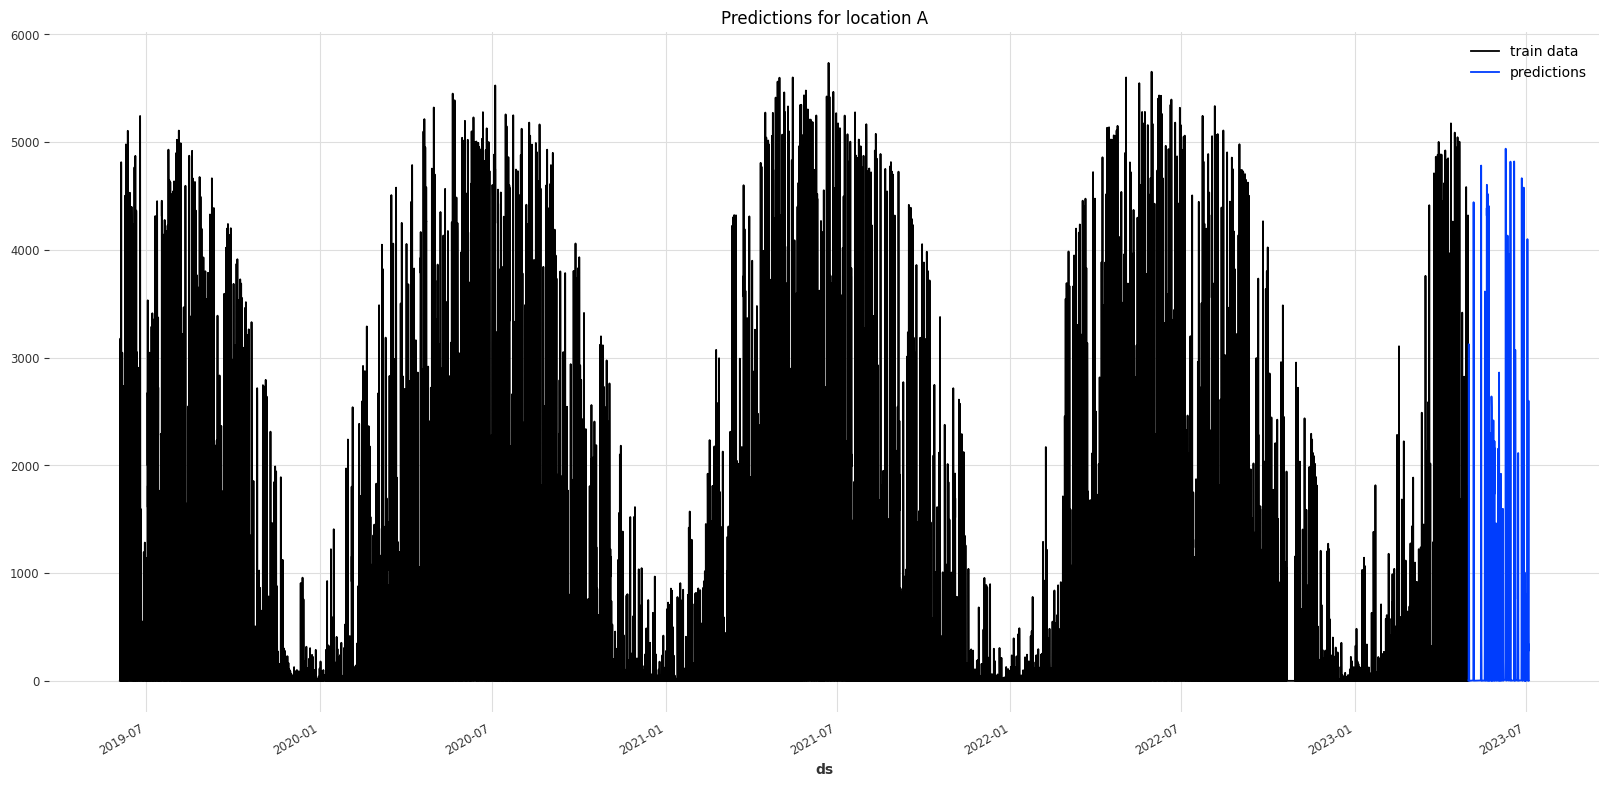

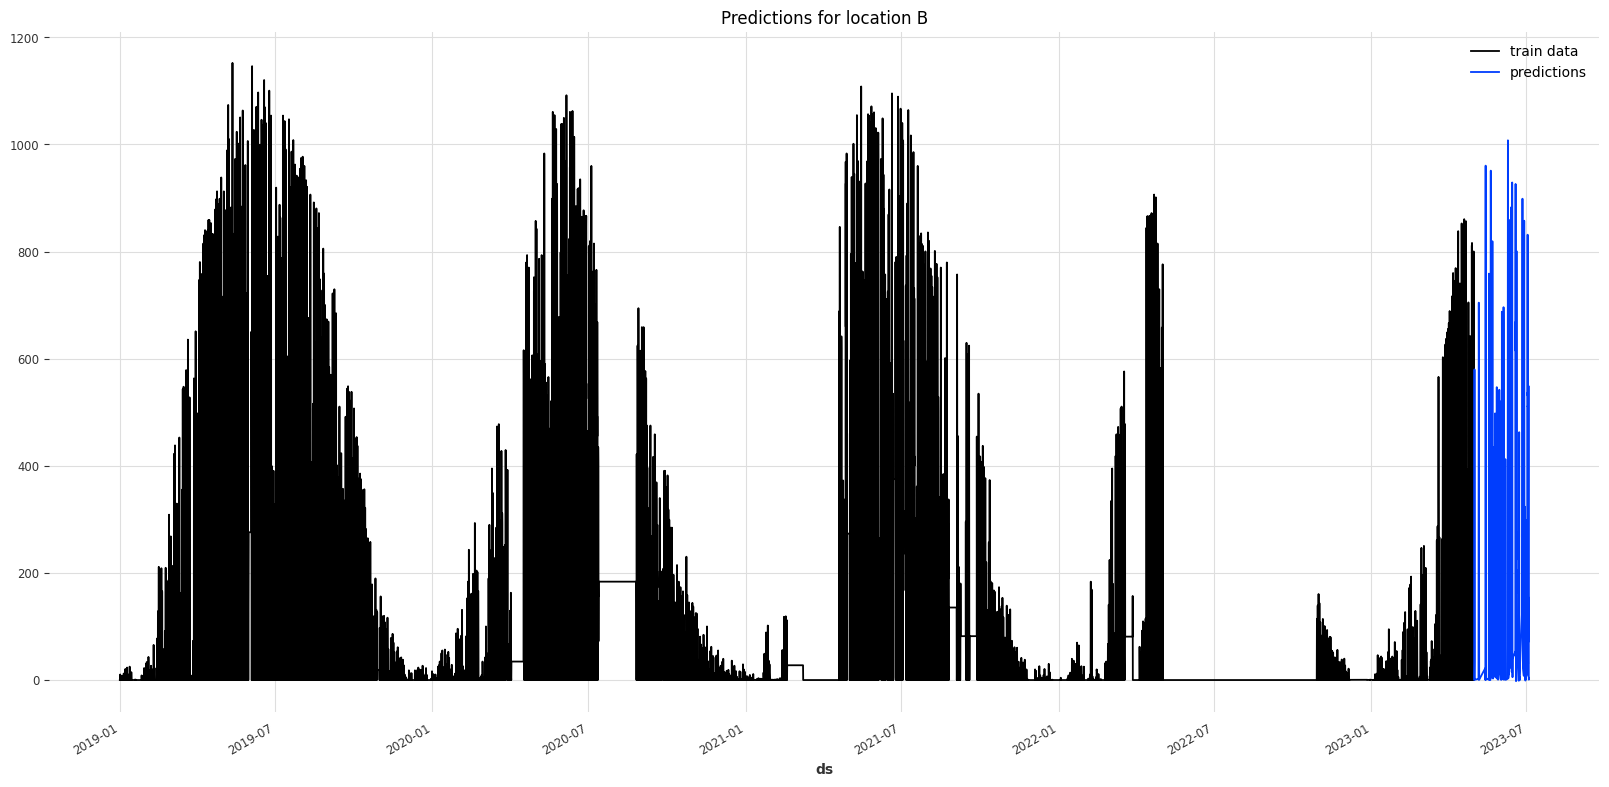

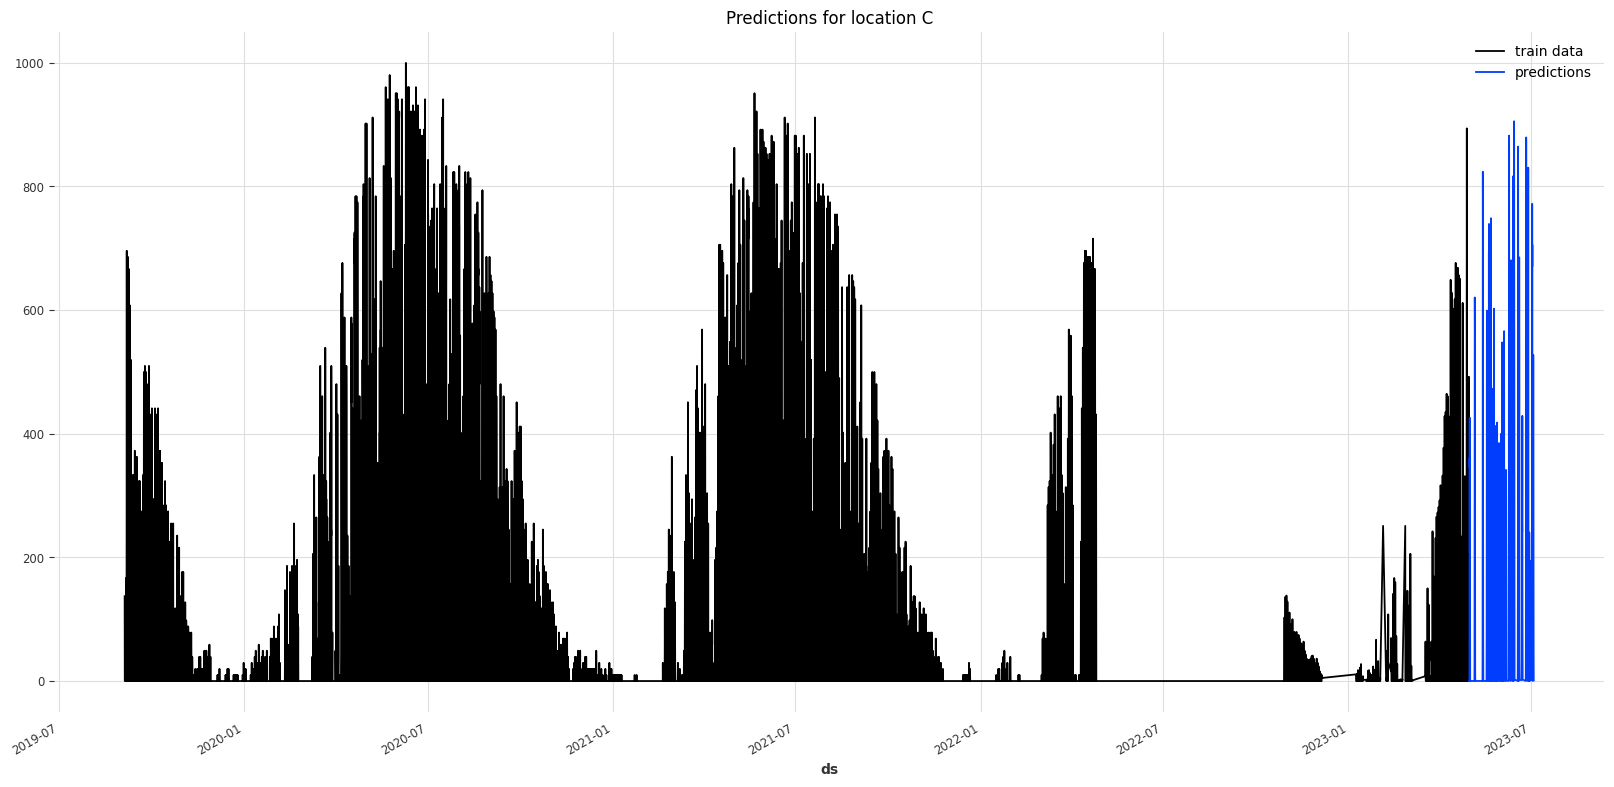

In [15]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # title
    ax.set_title(f"Predictions for location {loc}")

In [16]:
# concatenate predictions
submissions_df = pd.concat(predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

,id,prediction
0,0,2.846197
1,1,2.923443
2,2,3.005310
3,3,51.197372
4,4,266.546478
...,...,...
715,2155,93.187904
716,2156,85.414459
717,2157,31.074415
718,2158,4.270400


In [17]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_71.csv


In [19]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_71_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_71_files/notebook_pdfs
[NbConvertApp] Writing 110734 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 272810 bytes to notebook_pdfs/submission_71.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_71.pdf', 'autogluon_each_location.ipynb'], returncode=0)